In [1]:
import scipy.io as sio

gt_path = 'data/jasper/jasper_ridge_gt.mat'
tmp = sio.loadmat(gt_path)

In [3]:
gt = tmp['data']

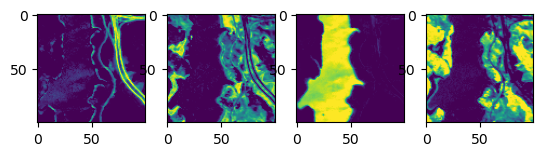

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4)
for i in range(4):
    axs[i].imshow(gt[:, :, i])
plt.show()

In [2]:
# so in the dataset the arrangement of classes are road, soil, water, tree

(100, 100, 4)

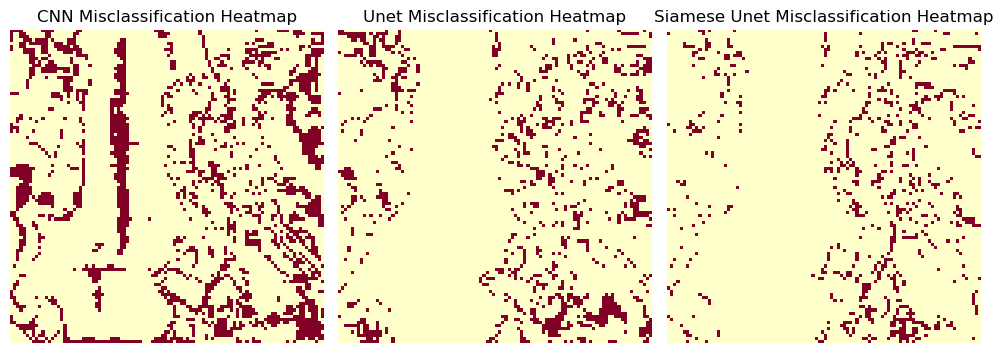

In [5]:
# plot misclassification heatmaps
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the color mapping for each class
color_mapping = {
    0: [128, 64, 128],  # Road - Purple
    1: [244, 164, 96],  # Soil - SandyBrown
    2: [0, 0, 255],     # Water - Blue
    3: [34, 139, 34],   # Tree - ForestGreen
}

# Function to convert an image to a label map
def image_to_label_map(image, color_mapping):
    h, w, _ = image.shape
    label_map = np.zeros((h, w), dtype=np.int32)
    for label, color in color_mapping.items():
        mask = np.all(image == color, axis=-1)
        label_map[mask] = label
    return label_map

# Function to create a misclassification heatmap
def create_heatmap(gt_labels, pred_labels):
    misclassification = (gt_labels != pred_labels).astype(np.float32)
    return misclassification

# Load ground truth and model prediction images
gt_image = np.array(Image.open('../images/gt.png'))
model1_image = np.array(Image.open('../images/cnn.png'))
model2_image = np.array(Image.open('../images/unet.png'))
model3_image = np.array(Image.open('../images/ca_siamese.png'))

# Convert images to label maps
gt_labels = image_to_label_map(gt_image, color_mapping)
model1_labels = image_to_label_map(model1_image, color_mapping)
model2_labels = image_to_label_map(model2_image, color_mapping)
model3_labels = image_to_label_map(model3_image, color_mapping)

# Create misclassification heatmaps
heatmap1 = create_heatmap(gt_labels, model1_labels)
heatmap2 = create_heatmap(gt_labels, model2_labels)
heatmap3 = create_heatmap(gt_labels, model3_labels)

# Save the heatmaps as images
plt.imsave('../images/cnn_heatmap.png', heatmap1, cmap='YlOrRd')
plt.imsave('../images/unet_heatmap.png', heatmap2, cmap='YlOrRd')
plt.imsave('../images/ca_siamese_heatmap.png', heatmap3, cmap='YlOrRd')

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(heatmap1, cmap='YlOrRd', interpolation='nearest')
axes[0].set_title('CNN Misclassification Heatmap')
axes[1].imshow(heatmap2, cmap='YlOrRd', interpolation='nearest')
axes[1].set_title('Unet Misclassification Heatmap')
axes[2].imshow(heatmap3, cmap='YlOrRd', interpolation='nearest')
axes[2].set_title('Siamese Unet Misclassification Heatmap')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import os
os.chdir("../")

In [2]:
import yaml
from datasets import dataset_factory
 
with open('configs/jasper_ridge.yaml', 'r') as file:
    config = yaml.safe_load(file)

dataset_name = config['dataset']['name']
train_dataset = dataset_factory[config['dataset']['name']](
                **config['dataset']['kwargs'], mode="train", 
                transforms=None)
sri, orig_rgb, gt = train_dataset.img_sri, train_dataset.img_rgb, train_dataset.gt

In [8]:
from PIL import ImageEnhance, Image
import numpy as np

image = Image.fromarray((orig_rgb*255).astype(np.uint8))
enhancer = ImageEnhance.Brightness(image)
low_light_image = enhancer.enhance(0.4)

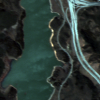

In [9]:
image

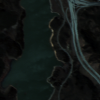

In [10]:
low_light_image

In [11]:
import cv2

def adjust_gamma(image, gamma=0.5):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)
# Step 2: Convert to OpenCV format for further processing
low_light_image_cv = cv2.cvtColor(np.array(low_light_image), cv2.COLOR_RGB2BGR)
# Step 3: Apply gamma correction
low_light_image_cv = adjust_gamma(low_light_image_cv, gamma=0.6)

In [13]:
low_light_image_cv = cv2.cvtColor(low_light_image_cv, cv2.COLOR_BGR2RGB)
final_im = Image.fromarray(low_light_image_cv)

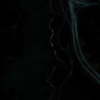

In [14]:
final_im

In [15]:
from datasets.contrast_enhancement import contrast_enhancement_multispectral

In [17]:
im_en = contrast_enhancement_multispectral(np.array(final_im), window_size=5, conductivity=0.95)

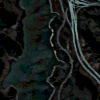

In [18]:
Image.fromarray(im_en)

In [16]:
from datasets.contrast_enhancement import contrast_enhancement_multispectral

In [8]:
from PIL import Image
import numpy as np

In [6]:
# lets just use gamma correction
def adjust_gamma_hyperspectral(image, gamma=0.5):
    # Calculate the inverse gamma
    invGamma = 1.0 / gamma
    # Initialize an array to store the gamma-corrected image
    gamma_corrected_image = np.zeros_like(image)
    # Apply gamma correction to each spectral band
    for band in range(image.shape[2]):
        # Normalize the band to [0, 1]
        normalized_band = image[:, :, band] / np.max(image[:, :, band])
        # Apply gamma correction
        gamma_corrected_band = np.power(normalized_band, invGamma)
        # Scale back to original range
        gamma_corrected_image[:, :, band] = gamma_corrected_band * np.max(image[:, :, band])
    return gamma_corrected_image




In [ ]:
before = Image.fromarray((orig_rgb*255).astype(np.uint8))

In [37]:
sri_dark = adjust_gamma_hyperspectral(sri, gamma=0.4)
after = train_dataset.get_rgb(sri_dark)
after = Image.fromarray((after*255).astype(np.uint8))

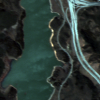

In [38]:
before

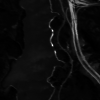

In [39]:
after

In [47]:
sri_en = contrast_enhancement((sri_dark*255).astype(np.uint8), window_size=5, conductivity=0.95)/255

In [48]:
after = train_dataset.get_rgb(sri_en)

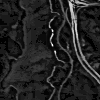

In [49]:
Image.fromarray((after*255).astype(np.uint8))

In [26]:
train_dataset.get_rgb(sri_en)

array([[[0.14864865, 0.14864865, 0.14864865],
        [0.12612613, 0.12612613, 0.12612613],
        [0.04954955, 0.04954955, 0.04954955],
        ...,
        [0.05405405, 0.05405405, 0.05405405],
        [0.25675676, 0.25675676, 0.25675676],
        [0.47747748, 0.47747748, 0.47747748]],

       [[0.17117117, 0.17117117, 0.17117117],
        [0.0990991 , 0.0990991 , 0.0990991 ],
        [0.05405405, 0.05405405, 0.05405405],
        ...,
        [0.06756757, 0.06756757, 0.06756757],
        [0.13963964, 0.13963964, 0.13963964],
        [0.04954955, 0.04954955, 0.04954955]],

       [[0.13963964, 0.13963964, 0.13963964],
        [0.09009009, 0.09009009, 0.09009009],
        [0.03153153, 0.03153153, 0.03153153],
        ...,
        [0.10810811, 0.10810811, 0.10810811],
        [0.08558559, 0.08558559, 0.08558559],
        [0.05855856, 0.05855856, 0.05855856]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.0045045 , 0.0045045 , 0.0045045 ],
        [0.01351351, 0